# Aztec Diamond Tiling

*Dmytro Fedoriaka, December 2020.*

In this notebook we consider tiling of  a grid called "Aztec Diamond" with 1x2 tiles (dominos).

First, we will implement an algorithm, which generates random tiling of order $n$ in $O(n^3)$ time and use it to sample some tilings. Then we will consider some applications of this algorithm.

References:

* W. Jockusch, J. Propp, P. Shor. Random Domino Tilings and the Arctic Circle Theorem ([link](https://arxiv.org/abs/math/9801068)).
* Animation of this algorithm: http://fedimser.github.io/adt/adt.html
* [Youtube video](https://www.youtube.com/watch?v=Yy7Q8IWNfHM) about this algorithm. 




## Random tiling algorithm

Below is implementation of algorithm described in referenced paper.

In [1]:
import numpy as np
import numba 
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import skimage.measure

# Convention: tiling of n-th order is represented by (2*n+2, 2*n+2) array.
# Each cell has value:
# 0 - empty.
# 1 - vertical, arrow to the left.
# 2 - horizontal, arrow to the top.
# 3 - vertical, arrow to the right.
# 4 - horizontal, arrow to the bottom.

@numba.jit("i1[:,:](i1[:,:])")
def iteration(old_map):
    """One step of the algorithm. 
    
    Given random tiling of order n-1, produces random tiling of order n.
    """
    n = old_map.shape[0] // 2 # Order of new tiling.
    assert old_map.shape == (2*n, 2*n)

    # Move all dominoes in their direction. unless they are clashing.
    # Also shift everytihg by (1, 1).
    new_map = np.zeros((2*n+2, 2*n+2), dtype=np.int8)
    for y in range(1, 2 * n - 1):
        for x in range(1, 2 * n - 1):
            if old_map[y][x]==1 and old_map[y][x-1] != 3:
                new_map[y+1][x-1+1]=1
            elif old_map[y][x]==2 and old_map[y-1][x] != 4:
                new_map[y-1+1][x+1]=2
            elif old_map[y][x]==3 and old_map[y][x+1] != 1:
                new_map[y+1][x+1+1]=3
            elif old_map[y][x]==4 and old_map[y+1][x] != 2:
                new_map[y+1+1][x+1]=4

    # Fill empty squares.
    for y in range(1, 2*n+1):
        dy = y - (n+1) if y>=(n+1) else (n+1)-1-y
        for x in range(1, 2*n+1):
            dx = x - (n+1) if x>=(n+1) else (n+1)-1-x            
            if dx+dy < n and new_map[y][x]==0:
                if np.random.random() > 0.5:
                    # Vertical pair.
                    new_map[y][x]=new_map[y+1][x]=1
                    new_map[y][x+1]=new_map[y+1][x+1]=3
                else:
                    # Horizontal pair.
                    new_map[y][x]=new_map[y][x+1]=2
                    new_map[y+1][x]=new_map[y+1][x+1]=4
    return new_map    

def random_tiling(order):
    """Generates random tiling of given order."""
    tiling = np.zeros((2,2), dtype=np.int8)
    for i in range(order):
        tiling = iteration(tiling)
    return tiling 

Let's see the algorithm in action. This is random tiling of order 20:

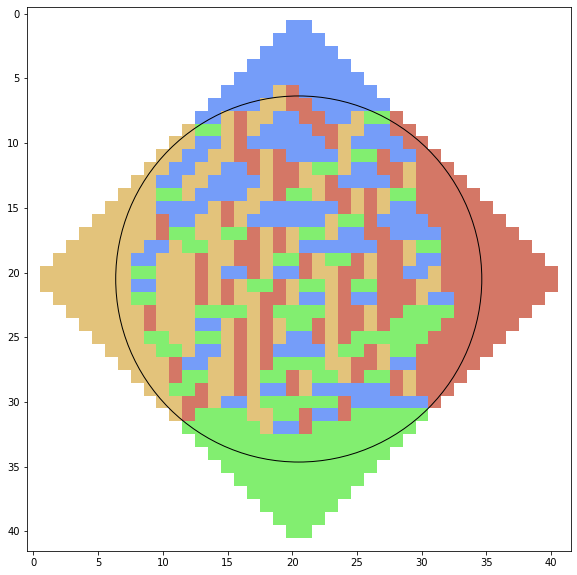

In [2]:
colormap = ListedColormap(np.array([
    [0xff,0xff,0xff],
    [0xe3,0xc3,0x7b],
    [0x75,0x9d,0xf9],
    [0xd4,0x77,0x66],
    [0x82,0xee,0x70],
])/255.0)

def show_random_tiling(order, with_circle=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    if with_circle:
        radius = order / np.sqrt(2)
        circle = Circle((order+0.5, order+0.5), radius, facecolor='none', edgecolor=(0, 0, 0), linewidth=1)
        ax.add_patch(circle)
    ax.imshow(random_tiling(order), cmap=colormap)
    
show_random_tiling(20)

Random tiling of order 75:

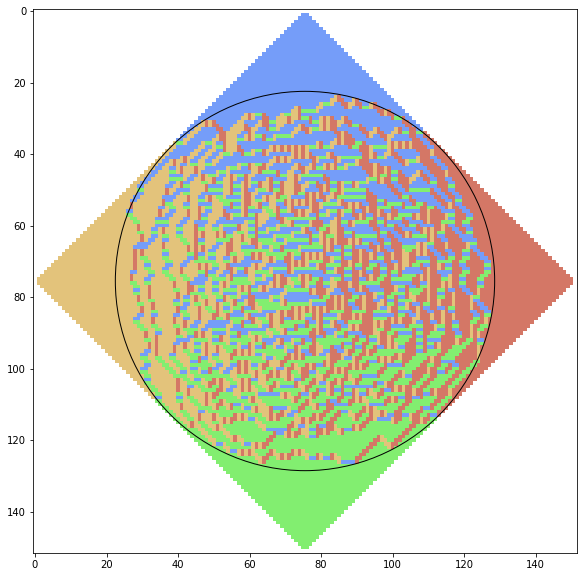

In [3]:
show_random_tiling(75)

Random tiling of order 200:

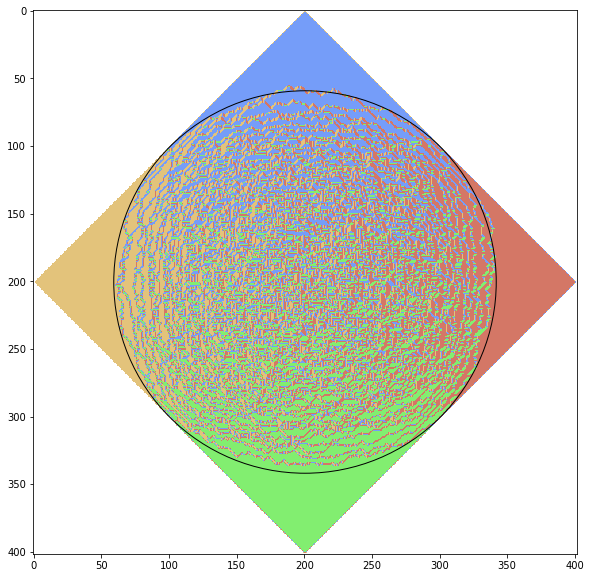

In [4]:
show_random_tiling(200)

We can clearly see frozen tiles at corners and circle in the middle, as predictaed by the Arctic Circle Theorem.

## Pi estimation

We can use this algorithm to estimate value of $\pi$. Let $f_n$ be number of "frozen" tiles at corners, $n$ - order of tiling (number of made iterations). Then total number of tiles is $n(n+1)$. Number of tiles which are not "frozen" is $n(n+1)-f_n$. 

On the other hand, ratio of area of circle to area of square in which it's inscribed is $\frac{\pi}{4}$ and the Arctic Circle Theorem tells us that as $n \to \infty$, non-frozen tiles form a circle. So,

$$\underset{n \to \infty}{\lim} \frac{n(n-1)-f_n}{n(n+1)} = 1 - \underset{n \to \infty}{\lim} \frac{f_n}{n(n+1)} = \frac{\pi}{4}$$

$$\pi = 4 - 4 \underset{n \to \infty}{\lim} \frac{f_n}{n(n+1)}$$

How to easily calculate frozen tiles? Let's find all connected regions on the picture and sort them by size. The biggest will be the background, four next will correspond to frozen corners - let's add them up, and divide by 2 (because each domino takes two cells). This will give correct result for sufficiently large n (say, $n>10$) because inside the circle huge connected components are improbable.

Now, let's estimate $\pi$ based on tilings with order from $100$ to $2000$.

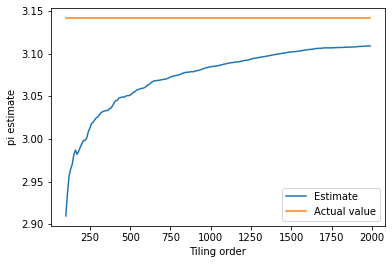

Last PI estimate: 3.109069


In [6]:
def frozen_tiles_count(tiling):
    connected_comp_sizes = np.sort(np.bincount(skimage.measure.label(tiling).reshape(-1)))
    return np.sum(connected_comp_sizes[-5:-1]) // 2

def estimate_pi(tiling):
    n = tiling.shape[0] // 2 - 1
    return 4.0 * (1.0 - 1.0 * frozen_tiles_count(tiling) / (n*(n+1)))

n0 = 100
n1 = 2000
tiling = random_tiling(n0)
n_range = []
pi_est = []
for n in range(n0, n1):
    if n % 10 == 0:
        n_range.append(n)
        pi_est.append(estimate_pi(tiling))
    tiling = iteration(tiling)
    
plt.plot(n_range, pi_est, label = 'Estimate')
plt.plot([n_range[0], n_range[-1]], [np.pi, np.pi], label = 'Actual value')
plt.xlabel('Tiling order')
plt.ylabel('pi estimate')
plt.legend()
plt.show()
print("Last PI estimate: %f" % pi_est[-1])

So, estimating $\pi$ from random tiling with order 1000 gives 3.08, which gives us 2% relative error.